In [1]:
from pathlib import Path

import dask.array as da
import matplotlib.pyplot as plt
import numpy as np
from ome_zarr.io import parse_url
from ome_zarr.writer import write_multiscale
import pandas as pd
import skimage.io as skio
import xmltodict
import zarr

In [2]:
# SELECT INPUT AND OUTPUT DIRECTORIES
maps_proj = Path(
    r"Z:\zmbstaff\9883\Raw_Data\9883-ec-03-from-7471-ec-04-sa-01-sc-01-i3-OK cells treated deferasirox"
)
output_dir = Path(
    r"Z:\zmbstaff\9883\Processed_Data\ome-zarrs\OK cells treated deferasirox"
)

In [3]:
ids = []
for pyramidXML_path in maps_proj.glob("**/pyramid.xml"):
    # data_dir = P
    image_pyramid = pyramidXML_path.parents[2]
    ids.append(image_pyramid)

print(f"found {len(ids)} image folders with pyramid-data:")
for image_pyramid in ids:
    print(str(image_pyramid).split(str(maps_proj))[1])

found 3 image folders with pyramid-data:
\LayersData\Layer\0.8 nm (2) (stitched)
\MetaData\3d312267-3e54-4906-82f4-556a2c80ca90\image_pyramid
\MetaData\ce2dd88b-cfe4-4346-bb34-d0d8b66ebe40\image_pyramid


In [4]:
# SELECT IMAGE FOLDER
img_folder = ids[0]
if img_folder.name == 'image_pyramid':
    img_id = img_folder.parent.name
else:
    img_id = img_folder.name
pyramid_data_path = list(img_folder.glob("*/data"))[0]

(1024, 1024)


(-0.5, 1023.5, 1023.5, -0.5)

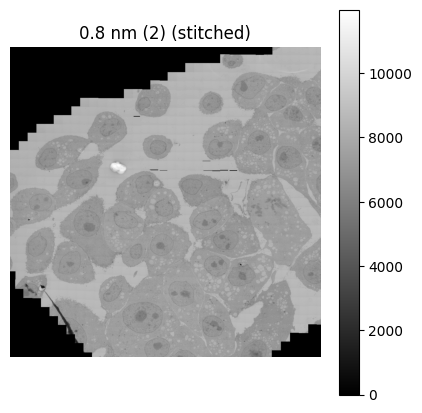

In [5]:
# looking at the lowest res image
lvl_0 = pyramid_data_path.joinpath("l_1", "c_0")

tile_0 = skio.imread(lvl_0.joinpath("tile_0.tif"), plugin="tifffile")
print(tile_0.shape)

plt.figure(figsize=(5, 5), dpi=100)
plt.imshow(tile_0, cmap="gray")
plt.colorbar()
plt.title(img_id)
plt.axis("off")

In [6]:
with open(image_pyramid.joinpath("MultiChannelParams.xml"), "rb") as f:
    multichannel_dict = xmltodict.parse(f, xml_attribs=True)

ch_name = multichannel_dict["MultiChannelParameters"]["Channel"]["Name"]
print(f"name of channel in image: {ch_name}")
multichannel_dict

name of channel in image: Default


{'MultiChannelParameters': {'@Count': '1',
  '@AdditiveAlpha': '-1',
  'Channel': {'@Index': '0',
   'Guid': '4693e535-ff8d-4326-b631-ffa568c08fd2',
   'Name': 'Default',
   'Additive': 'False',
   'Inverted': 'False',
   'Visible': 'True',
   'Color': {'@A': '255', '@R': '255', '@G': '255', '@B': '255'},
   'PixelMin': '0.00338750286106661',
   'PixelMax': '0.0186160067139696',
   'CameraPixelMax': '1',
   'CameraScale': '65535',
   'ComputedPixelMin': '0',
   'ComputedPixelMax': '1',
   'Opacity': '1',
   'Gamma': '1',
   'ZeroIsTransparent': 'True',
   'SaturationWarningEnabled': 'False'}}}

In [7]:
with open(pyramid_data_path.joinpath("pyramid.xml"), "rb") as f:
    pyramid_dict = xmltodict.parse(f, xml_attribs=True)
pyramid_dict

{'root': {'imageset': {'@url': 'l_{l}/c_{c}/tile_{r}.tif',
   '@levels': '9',
   '@width': '190032',
   '@height': '168112',
   '@tileWidth': '1024',
   '@tileHeight': '1024',
   '@tileOverlap': '0',
   '@projection': 'perspective',
   '@maxZoom': '4',
   '@step': '2',
   '@subRect': '0 0 190032 168112'},
  'metadata': {'physicalsize': {'x': '1.561479e-004', 'y': '1.381364e-004'},
   'pixelsize': {'x': '8.216927e-010', 'y': '8.216927e-010'}}}}

In [8]:
n_lvl = pyramid_dict["root"]["imageset"]["@levels"]
height = pyramid_dict["root"]["imageset"]["@height"]
width = pyramid_dict["root"]["imageset"]["@width"]
overlap = pyramid_dict["root"]["imageset"]["@tileOverlap"]
res_step = pyramid_dict["root"]["imageset"]["@step"]
t_w = pyramid_dict["root"]["imageset"]["@tileWidth"]
t_h = pyramid_dict["root"]["imageset"]["@tileHeight"]

print(f"The pyramid has {n_lvl} levels")
print(f"total img size: {width} x {height}, not counting black padding")
print(f"with an overlap of: {overlap}")
print(f"the resolution step is: {res_step}")
print(f"single image shape: {t_w} x {t_h}")

pix_size_x = pyramid_dict["root"]["metadata"]["pixelsize"]["x"]
pix_size_y = pyramid_dict["root"]["metadata"]["pixelsize"]["y"]

print(f"the pixel size is: {pix_size_x} m")

The pyramid has 9 levels
total img size: 190032 x 168112, not counting black padding
with an overlap of: 0
the resolution step is: 2
single image shape: 1024 x 1024
the pixel size is: 8.216927e-010 m


In [9]:
full_res_path = pyramid_data_path.joinpath(f'l_{int(n_lvl)-1}')

col_folders = [
    f for f in full_res_path.iterdir() if f.is_dir() and f.name.startswith('c_')
]

print(f'found {len(col_folders)} column folders')

found 186 column folders


In [10]:
col_idx = 0
col_folder = col_folders[col_idx]

col_tiles = [
    f for f in col_folder.iterdir() if f.is_file and f.name.endswith('.tif')
]
n_tiles = len(col_tiles)
print(f'found {n_tiles} tiles in col {col_idx}')

found 51 tiles in col 0


In [11]:
def get_col_df(col_folder):
    #col_folder = col_folders[col_idx]
    c_name = str(col_folder.name).split('c_')
    c_name = c_name[1]
    col_tiles = [f for f in col_folder.iterdir() if f.is_file and f.name.endswith('.tif')]

    tmp_img = skio.imread(col_tiles[0], plugin="tifffile")
    img_dtype = tmp_img.dtype

    #n_tiles = len(col_tiles)
    col_df = pd.DataFrame(
        columns=[
            'row_idx',
            'col_idx',
            'tif_path',
            'corner_row',
            'corner_col',
            'size_row',
            'size_col',
            'data_type'
        ]
    )
    col_df['tif_path'] = col_tiles
    col_df['col_idx'] = c_name
    col_df['data_type'] = img_dtype
    col_df['size_row'] = tmp_img.shape[0]
    col_df['size_col'] = tmp_img.shape[1]


    row_idx = []
    cor_row = []
    cor_col = []

    for val in col_tiles:
        t_name = str(val.name).split("tile_")[1].split(".")[0]
        idx = int(t_name)
        row_idx.append(idx)
        cor_row.append(idx * tmp_img.shape[0])
        cor_col.append(int(c_name) * tmp_img.shape[1])

    col_df['row_idx'] = row_idx
    col_df['corner_row'] = cor_row
    col_df['corner_col'] = cor_col

    return col_df

def rm_tree(pth):
    pth = Path(pth)
    for child in pth.glob('*'):
        if child.is_file():
            child.unlink()
        else:
            rm_tree(child)
    pth.rmdir()

In [12]:
col_list = []
for col_folder in (col_folders):

    col_list.append(get_col_df(col_folder))

# concatenating df1 and df2 along rows
total_df = pd.concat(col_list, axis=0)
total_df.reset_index(drop=True, inplace=True)
total_df

,row_idx,col_idx,tif_path,corner_row,corner_col,size_row,size_col,data_type
0,42,0,Z:\zmbstaff\9883\Raw_Data\9883-ec-03-from-7471...,43008,0,1024,1024,uint16
1,43,0,Z:\zmbstaff\9883\Raw_Data\9883-ec-03-from-7471...,44032,0,1024,1024,uint16
2,44,0,Z:\zmbstaff\9883\Raw_Data\9883-ec-03-from-7471...,45056,0,1024,1024,uint16
3,45,0,Z:\zmbstaff\9883\Raw_Data\9883-ec-03-from-7471...,46080,0,1024,1024,uint16
4,46,0,Z:\zmbstaff\9883\Raw_Data\9883-ec-03-from-7471...,47104,0,1024,1024,uint16
...,...,...,...,...,...,...,...,...
21110,95,99,Z:\zmbstaff\9883\Raw_Data\9883-ec-03-from-7471...,97280,101376,1024,1024,uint16
21111,96,99,Z:\zmbstaff\9883\Raw_Data\9883-ec-03-from-7471...,98304,101376,1024,1024,uint16
21112,97,99,Z:\zmbstaff\9883\Raw_Data\9883-ec-03-from-7471...,99328,101376,1024,1024,uint16
21113,98,99,Z:\zmbstaff\9883\Raw_Data\9883-ec-03-from-7471...,100352,101376,1024,1024,uint16


In [13]:
# total_df = get_col_df(col_folders, 2) # for testing

max_row = total_df.loc[total_df['corner_row'].idxmax()]
max_col = total_df.loc[total_df['corner_col'].idxmax()]
total_row = max_row['corner_row'] + max_row['size_row']
total_col = max_col['corner_col'] + max_col['size_col']
total_dype = max_col['data_type']
print(f'total image size: {total_row}, {total_col}')

total image size: 168960, 190464


In [14]:
z0_str = f"./{img_id}.zarr"
z0_path = Path(z0_str)

if z0_path.exists():
    rm_tree(z0_path)

store = zarr.DirectoryStore(z0_path)
chunk_size = total_df["size_row"].max()
print(f"Chunk size: {chunk_size},{chunk_size}")
z = zarr.creation.open_array(
    store=store,
    mode="a",
    shape=(total_row, total_col),
    chunks=(chunk_size, chunk_size),
    dtype=total_dype,
)
z

Chunk size: 1024,1024


<zarr.core.Array (168960, 190464) uint16>

In [15]:
%%time
for index, row in total_df.iterrows():
    tmp_img = skio.imread(row["tif_path"], plugin="tifffile")

    row_1 = row["corner_row"]
    row_2 = row_1 + row["size_row"]
    col_1 = row["corner_col"]
    col_2 = col_1 + row["size_col"]

    z[row_1:row_2, col_1:col_2] = tmp_img

CPU times: total: 11min 56s
Wall time: 25min 34s


In [16]:
# like numpy.mean, but maintains dtype, helper function
def mean_dtype(arr, **kwargs):
    return np.mean(arr, **kwargs).astype(arr.dtype)

In [17]:
# it is still not quite clear to me why, but we need to rechunk de data at this stage
# if not zarr writting later on will fail
d0 = da.from_zarr(store).rechunk(chunk_size,chunk_size)
d0

dask.array<from-zarr, shape=(168960, 190464), dtype=uint16, chunksize=(1024, 1024), chunktype=numpy.ndarray>

In [18]:
d1 = da.coarsen(mean_dtype, d0, {0:2,1:2}).rechunk(int(chunk_size/2),int(chunk_size/2))

d2 = da.coarsen(mean_dtype, d0, {0:4,1:4}).rechunk(int(chunk_size/2),int(chunk_size/2))

d3 = da.coarsen(mean_dtype, d0, {0:8,1:8}).rechunk(int(chunk_size/2),int(chunk_size/2))
d3

dask.array<rechunk-merge, shape=(21120, 23808), dtype=uint16, chunksize=(512, 512), chunktype=numpy.ndarray>

In [19]:
# I can probably build this programmatically, for the moment I take a shortcut. 
# This assumes an image with full resolution and one downscale by 2x2
# here I assume that the original scale was in m but I am not sure

initial_pix_size = float(pix_size_x) / 1e-9
initial_pix_unit = 'nanometer'
coordtfs = [
        [{'type': 'scale', 'scale': [initial_pix_size,initial_pix_size]},
         {'type': 'translation', 'translation': [0, 0]}],
        [{'type': 'scale', 'scale': [initial_pix_size*2,initial_pix_size*2]},
         {'type': 'translation', 'translation': [0, 0]}],
        [{'type': 'scale', 'scale': [initial_pix_size*4,initial_pix_size*4]},
         {'type': 'translation', 'translation': [0, 0]}],
        [{'type': 'scale', 'scale': [initial_pix_size*8,initial_pix_size*8]},
         {'type': 'translation', 'translation': [0, 0]}],
        ]
axes = [{'name': 'y', 'type': 'space', 'unit': initial_pix_unit},
        {'name': 'x', 'type': 'space', 'unit': initial_pix_unit}]

In [20]:
%%time
path = output_dir / (img_id+"-ome.zarr")

if path.exists():
  rm_tree(path)


store = parse_url(path, mode='w').store
root = zarr.group(store=store)

# Use OME write multiscale;
write_multiscale([d0, d1, d2, d3],
        group=root, axes=axes, coordinate_transformations=coordtfs
        )
# add omero metadata: the napari ome-zarr plugin uses this to pass rendering
# options to napari.
root.attrs['omero'] = {
        'channels': [{
                'color': 'ffffff',
                'label': ch_name,
                'active': True,
                'window': {
                  'end': d0.max().compute(),
                  'max': 65535,
                  'start': d0.min().compute(),
                  'min': 0,
                }
                }]
        }

CPU times: total: 29min 57s
Wall time: 6min 50s


In [21]:
if z0_path.exists():
  rm_tree(z0_path)